# Environment Setup

To start working with Flower, very little is required once you have activated your Python environment (e.g. via `conda`, `virtualenv`, `pyenv`, etc). If you are running this code on Colab, there is really nothing to do except to install Flower and other dependencies. The steps below have been verified to run in Colab.

## Installing Flower

You can install flower very conveniently from `pip`:

In [1]:
# depending on your shell, you might need to add `\` before `[` and `]`.
!pip install -q flwr[simulation]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.4/200.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 10.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 35.9 MB/s eta 0:00:00


We will be using the _simulation_ mode in Flower, which allows you to run a large number of clients without the overheads of manually managing devices. This is achieved via the [Virtual Client Engine]() in Flower. With simulation, you can dynamically scale your experiments whether you run the code on your laptop, a machine with a single GPU, a server with multiple GPUs os even on a cluster with multiple servers. The `Virtual Client Engine` handles everything transparently and it allows you to specify how many resources (e.g. CPU cores, GPU VRAM) should be assigned to each virtual client.


Flower is agnostic to your choice of ML Framework. Flower works with `PyTorch`, `Tensorflow`, `NumPy`, `🤗 Transformers`, `MXNet`, `JAX`, `scikit-learn`, `fastai`, `Pandas`. Flower also supports all major platforms: `iOS`, `Android` and plain `C++`. You can find a _quickstart-_ example for each of the above in the [Flower Repository](https://github.com/adap/flower/tree/main/examples) inside the `examples/` directory.

In this tutorial we are going to use PyTorch, so let's install a recent version. In this tutorial we'll use a small model so using CPU only training will suffice (this will also prevent Colab from abruptly terminating your experiment if resource limits are exceeded)

In [2]:
# Install Pytorch with CPU support. Please adjust this command for your platform or if you want to use a GPU
!pip install torch==1.13.1+cpu torchvision==0.14.1+cpu torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 1.4 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu118
    Uninstalling torch-2.1.0+cu118:
      Successfully uninstalled torch-2.1.0+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.16.0+cu118
    Uninstalling torchvision-0.16.0+cu118:
      Successfully uninstalled torchvision-0.16.0+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.1.0+cu118
    Uninstalling torchaudio-2.1.0+cu118:
      Successfully uninstalled torchaudio-2.1.0+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sou

We are going to install some other dependencies you are likely familiar with. We'll use these to make plots.

In [3]:
!pip install matplotlib

# Centralised training: the old way of doing ML

Let's begin by creating a simple (but complete) training loop as it is commonly done in centralised setups. Starting our tutorial in this way will allow us to very clearly identify which parts of a typical ML pipeline are common to both centralised and federated training.

For this tutorial we'll design a image classification pipeline for [MNIST digits](https://en.wikipedia.org/wiki/MNIST_database) and using a simple CNN model as the network to train. The MNIST dataset is comprised of `28x28` greyscale images with digits from 0 to 9 (i.e. 10 classes in total)


## A dataset

Let's begin by constructing the dataset.

In [4]:
# we naturally first need to import torch and torchvision
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST


def get_mnist(data_path: str = "./data"):
    """This function downloads the MNIST dataset into the `data_path`
    directory if it is not there already. We construct the train/test
    split by converting the images into tensors and normalizing them"""

    # transformation to convert images to tensors and apply normalization
    tr = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

    # prepare train and test set
    trainset = MNIST(data_path, train=True, download=True, transform=tr)
    testset = MNIST(data_path, train=False, download=True, transform=tr)

    return trainset, testset

Let's run the code above and do some visualisations to understand better the data we are working with !

In [5]:
trainset, testset = get_mnist()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



We can have a quick overview of our datasets by just typing the object on the command line. For instance, below you can see that the `trainset` has 60k training examples and will use the transformation rule we defined above in `get_mnist()`.

In [6]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

Let's create a more insightful visualisation. First let's see the distribution over the labels by constructing a histogram. Then, let's visualise some training examples !

Text(0.5, 1.0, 'Class labels distribution for MNIST')

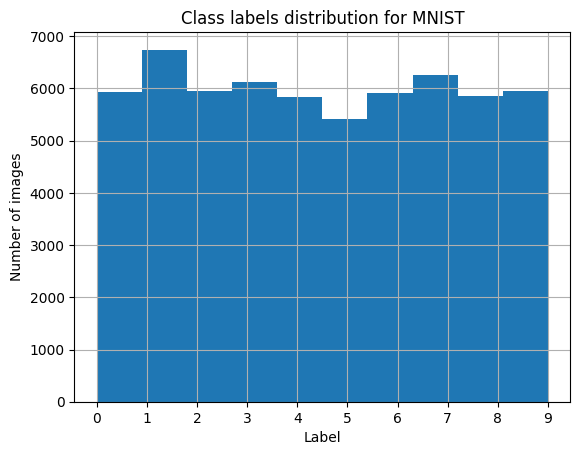

In [7]:
import matplotlib.pyplot as plt


# construct histogram
all_labels = trainset.targets
num_possible_labels = len(
    set(all_labels.numpy().tolist())
)  # this counts unique labels (so it should be = 10)
plt.hist(all_labels, bins=num_possible_labels)

# plot formatting
plt.xticks(range(num_possible_labels))
plt.grid()
plt.xlabel("Label")
plt.ylabel("Number of images")
plt.title("Class labels distribution for MNIST")

In [8]:
import random
import numpy as np


def visualise_n_random_examples(trainset_, n: int, verbose: bool = True):
    # take n examples at random
    idx = list(range(len(trainset_.data)))
    random.shuffle(idx)
    idx = idx[:n]
    if verbose:
        print(f"will display images with idx: {idx}")

    # construct canvas
    num_cols = 8
    num_rows = int(np.ceil(len(idx) / num_cols))
    fig, axs = plt.subplots(figsize=(16, num_rows * 2), nrows=num_rows, ncols=num_cols)

    # display images on canvas
    for c_i, i in enumerate(idx):
        axs.flat[c_i].imshow(trainset_.data[i], cmap="gray")

Let's visualise 32 images from the dataset


will display images with idx: [42369, 20508, 15499, 51039, 32206, 16937, 19462, 2180, 43242, 1260, 21806, 5645, 3985, 22524, 16677, 5196, 9520, 31572, 10206, 57124, 55591, 8150, 58028, 45767, 53189, 45615, 16569, 51910, 2921, 32098, 23635, 31117]


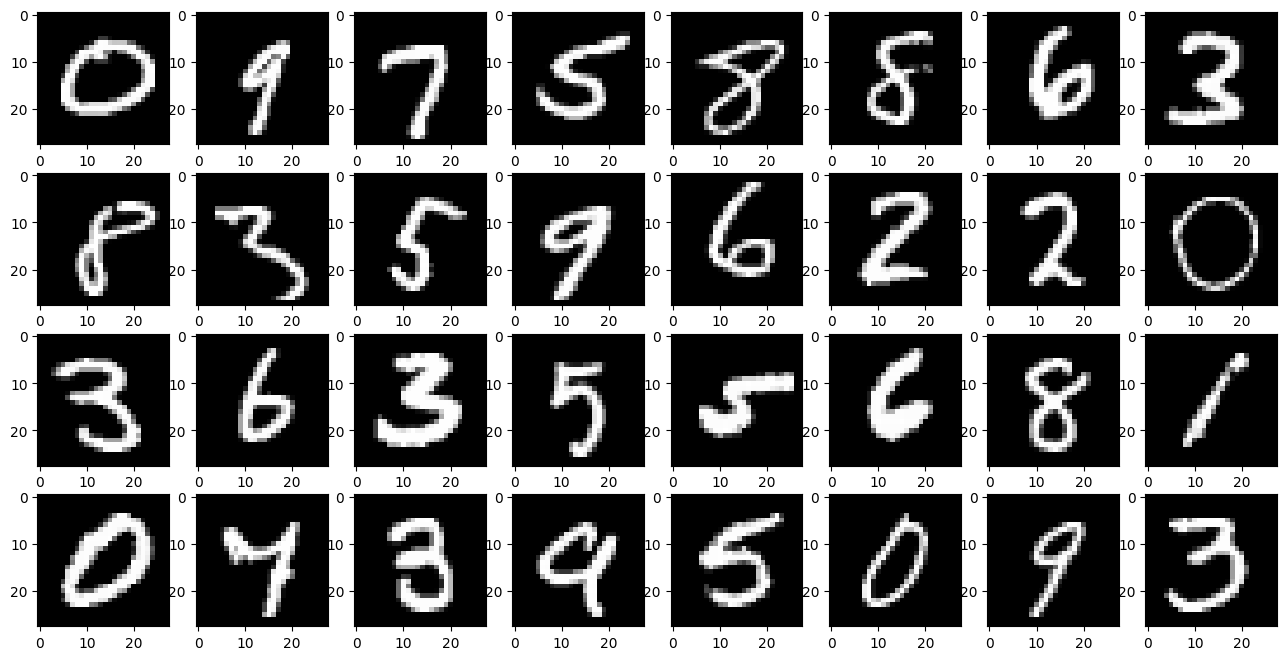

In [9]:
# it is likely that the plot this function will generate looks familiar to other plots you might have generated before
# or you might have encountered in other tutorials. So far, we aren't doing anything new, Federated Learning will start soon!
visualise_n_random_examples(trainset, n=32)

# Preparing the experiment

This tutorial is not so much about novel architectural designs so we keep things simple and make use of a typical CNN that is adequate for the MNIST image classification task.



In [10]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

We'll be training the model in a Federated setting. In order to do that, we need to define two functions:

* `train()` that will train the model given a dataloader.
* `test()` that will be used to evaluate the performance of the model on held-out data, e.g., a training set.

In [11]:
def train(net, trainloader, optimizer, epochs, device):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    for _ in range(epochs):
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(net(images), labels)
            loss.backward()
            # Perform gradient clipping for numerical stability
            # torch.nn.utils.clip_grad_value_(net.parameters(), 10)
            optimizer.step()
    return net


def test(net, testloader, device):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy

The code we have written so far is not specific to Federated Learning. Then, what are the key differences between Federated Learning and Centralised Training? If you could only pick you, probably you'd say:
* Federated Learning is distributed -- the model is trained on-device by the participating clients.
* Data remains private and is owned by a specific _client_ -- the data is never sent to the central server.

The are several more differences. But the above two are the main ones to always consider and that are common to all flavours of Federated Learning (e.g. _cross-device_ or _cross-silo_). The remaining of this tutorial is going to focus in transforming the code we have written so far for the centralised setting and construct a Federated Learning pipeline using Flower and PyTorch.

Let's begin! 🚀

## One Client, One Data Partition

To start designing a Federated Learning pipeline we need to meet one of the key properties in FL: each client has its own data partition. To accomplish this with the MNIST dataset, we are going to generate N random partitions, where N is the total number of clients in our FL system.

In [12]:
from torch.utils.data import random_split


def prepare_dataset(num_partitions: int, batch_size: int, val_ratio: float = 0.1):
    """This function partitions the training set into N disjoint
    subsets, each will become the local dataset of a client. This
    function also subsequently partitions each training set partition
    into train and validation. The test set is left intact and will
    be used by the central server to asses the performance of the
    global model."""

    # get the MNIST datatset
    trainset, testset = get_mnist()

    # split trainset into `num_partitions` trainsets
    num_images = len(trainset) // num_partitions

    partition_len = [num_images] * num_partitions

    trainsets = random_split(
        trainset, partition_len, torch.Generator().manual_seed(2023)
    )

    # create dataloaders with train+val support
    trainloaders = []
    valloaders = []
    for trainset_ in trainsets:
        num_total = len(trainset_)
        num_val = int(val_ratio * num_total)
        num_train = num_total - num_val

        for_train, for_val = random_split(
            trainset_, [num_train, num_val], torch.Generator().manual_seed(2023)
        )

        trainloaders.append(
            DataLoader(for_train, batch_size=batch_size, shuffle=True, num_workers=2)
        )
        valloaders.append(
            DataLoader(for_val, batch_size=batch_size, shuffle=False, num_workers=2)
        )

    # create dataloader for the test set
    testloader = DataLoader(testset, batch_size=128)

    return trainloaders, valloaders, testloader

Let's create 100 partitions and extract some statistics from one partition


number of images: 540


Text(0.5, 1.0, 'Class labels distribution for MNIST')

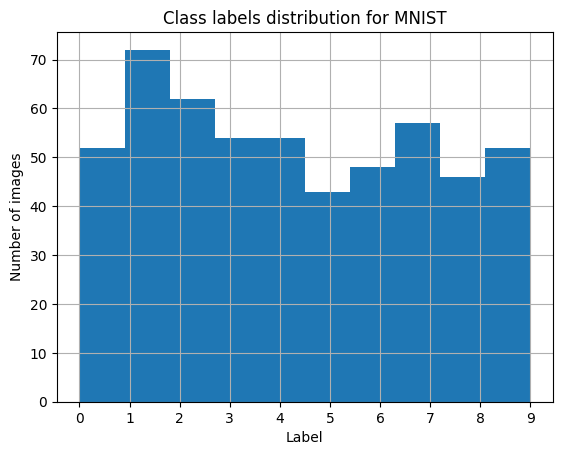

In [13]:
NUM_CLIENTS = 100

trainloaders, valloaders, testloader = prepare_dataset(
    num_partitions=NUM_CLIENTS, batch_size=32
)

# first partition
train_partition = trainloaders[0].dataset

# count data points
partition_indices = train_partition.indices
print(f"number of images: {len(partition_indices)}")

# visualise histogram
plt.hist(train_partition.dataset.dataset.targets[partition_indices], bins=10)
plt.grid()
plt.xticks(range(10))
plt.xlabel("Label")
plt.ylabel("Number of images")
plt.title("Class labels distribution for MNIST")

As you can see, the histogram of this partition is a bit different from the one we obtained at the beginning where we took the entire dataset into consideration. Because our data partitions are artificially constructed by sampling the MNIST dataset in an IID fashion, our Federated Learning example will not face sever _data heterogeneity_ issues (which is a fairly [active research topic](https://arxiv.org/abs/1912.04977)).

Let's next define how our FL clients will behave

## Defining a Flower Client

You can think of a client in FL as an entity that owns some data and trains a model using this data. The caveat is that the model is being trained _collaboratively_ in Federation by multiple clients (sometimes up to hundreds of thousands) and, in most instances of FL, is sent by a central server.

A Flower Client is a simple Python class with four distinct methods:

* `fit()`: With this method, the client does on-device training for a number of epochs using its own data. At the end, the resulting model is sent back to the server for aggregation.

* `evaluate()`: With this method, the server can evaluate the performance of the global model on the local validation set of a client. This can be used for instance when there is no centralised dataset on the server for validation/test. Also, this method can be use to asses the degree of personalisation of the model being federated.

* `set_parameters()`: This method takes the parameters sent by the server and uses them to initialise the parameters of the local model that is ML framework specific (e.g. TF, Pytorch, etc).

* `get_parameters()`: It extract the parameters from the local model and transforms them into a list of NumPy arrays. This ML framework-agnostic representation of the model will be sent to the server.

Let's start by importing Flower!

In [14]:
import flwr as fl

## Quantization

Insert your function for quantization here.
The input is a vector provided as a numpy array.
The function should return a numpy array with the same shape as input, and should correspond to the *reconstructed* vector, i.e., the $\hat{x}$ vector.

You should implement the following quantization schemes:
- Deterministic rounding and Randomized rounding
  - k = 2,3,4
- Random rotations, followed by deterministic rounding and randomized rounding
  For this, split the array into sub-arrays of size 128 and multiply each sub-array with a random rotation matrix. This is to keep the computational complexity in control
  - k = 2,3

Plot the round vs accuracy for all of these

In [15]:

from scipy.stats import ortho_group

"""
Quantizer class to pass parameters for quantization
"""
class Quantizer:

  """
  Function to initialize the quantizer class
  """
  def __init__(self):
    self.config = {}
    self.config['rr'] = False
    self.config['sr'] = None
    self.config['k'] = 0

  """
  Function to set quantizer configuration
  """
  def set_config(self, rr: bool = False, sr: str = None, k: int = 0):
    self.config['rr'] = rr
    self.config['sr'] = sr
    self.config['k'] = k

  """
  Function to get quantizer configuration
  """
  def get_config(self):
    return self.config

  """
  Let us now create a function to quantize a numpy array
  """
  def quantize(self, input_vector):
    array_len = np.size(input_vector)
    #input_vector is a numpy array of shape (array_len,)
    #quantized_vector should also be a numpy array of the same dimensions,
    #  and should correspond to the reconstructed vector after quantization
    # Useful properties of input_vector
    x_min = np.min(input_vector)
    x_max = np.max(input_vector)
    quantized_vector = input_vector.copy()
    # Get quantizer config
    config = self.get_config()
    rr = config['rr']
    sr = config['sr']
    k = config['k']

    # Multiply with random rotation matrix if needed
    inv_list = []
    len = 128
    if rr:
      i = 0
      while i < array_len:
        # Generate a random orthonormal rotation matrix of appropriate size
        rot_matrix = ortho_group.rvs(dim=min(len, array_len - i))
        # Multiply with input_vector slice
        quantized_vector[i:i+len] = quantized_vector[i:i+len]@rot_matrix
        # Update i to next slice
        i += len
        # Add inverse/transpose for reconstruction
        inv_list.append(rot_matrix.T)

    # Normalize the vector entries to [0, 1]
    quantized_vector = (quantized_vector - x_min*np.ones_like(input_vector))/(x_max - x_min)
    # Perform deterministic or randomized rounding
    if sr == 'det':
      # X <-- (round(x*(2^k)) + 0.5)/(2^k)
      quantized_vector = np.round(quantized_vector*(2**k))/(2**k) + np.ones_like(input_vector)/(2**(k + 1))
      quantized_vector[input_vector > 1] -= 2**(-k)
    elif sr == 'rand':
      # Create a numpy random.Generator object
      rng = np.random.default_rng()
      # Add a random number between [0, 1)
      # Notice that this is equivalent to creating Bernoulli samples
      # using uniform[0, 1] random variables.
      quantized_vector = (np.floor(quantized_vector*(2**k - 1) + rng.random(input_vector.shape)))/(2**k - 1)
    elif sr == None:
      pass
    else:
      raise Exception('Scalar quantization scheme entered is incorrect.')

    # Scale back to [x_min, x_max]
    quantized_vector = x_min*np.ones_like(input_vector) + (x_max - x_min)*quantized_vector

    # If randomized rotation was used, multiply slices with inverses
    if rr:
      i = 0
      for arr in inv_list:
        quantized_vector[i:i+len] = quantized_vector[i:i+len]@arr
        i += len


    return(quantized_vector)

# Instantiate a Quantizer object
qr = Quantizer()

Now let's define our Flower Client class:

In [16]:
from collections import OrderedDict
from typing import Dict, List, Tuple

import torch
from flwr.common import NDArrays, Scalar


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, trainloader, vallodaer) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = vallodaer
        self.model = Net(num_classes=10)
        # Determine device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)  # send model to device

    def set_parameters(self, parameters):
        """With the model paramters received from the server,
        overwrite the uninitialise model in this class with them."""

        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        # now replace the parameters
        self.model.load_state_dict(state_dict, strict=True)

    def get_parameters(self, config: Dict[str, Scalar]):
        """Extract all model parameters and conver them to a list of
        NumPy arryas. The server doesn't work with PyTorch/TF/etc."""

        np_arrays = [val.cpu().numpy() for _, val in self.model.state_dict().items()]
        # np_arrays is a list of numpy arrays
        array_sizes = np.array([np.size(x) for x in np_arrays])
        #print(array_sizes)
        array_shapes = [np.shape(x) for x in np_arrays]
        #print(array_shapes)
        concat_size = np.sum(array_sizes)
        reshaped_arrays = [x.reshape(np.size(x)) for x in np_arrays]
        concat_array = np.array([a for x in reshaped_arrays for a in x])
        #print(np.shape(concat_array))
        #print(concat_size)

        quantized_array = qr.quantize(concat_array)
        quantized_list_arrays = []
        for i in range(np.size(array_sizes)):
          init_loc = 0
          if (i>0):
            init_loc = np.sum(array_sizes[:i])
          final_loc = np.sum(array_sizes[:(i+1)])
          reshaped_subarray = (quantized_array[init_loc:final_loc]).reshape(array_shapes[i])
          quantized_list_arrays.append(reshaped_subarray)


        return quantized_list_arrays

    def fit(self, parameters, config):
        """This method train the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""

        # copy parameters sent by the server into client's local model
        self.set_parameters(parameters)

        # read from config
        lr, epochs = config["lr"], config["epochs"]

        # Define the optimizer
        optim = torch.optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)

        # do local training
        train(self.model, self.trainloader, optim, epochs=epochs, device=self.device)

        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return self.get_parameters({}), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""

        self.set_parameters(parameters)
        loss, accuracy = test(self.model, self.valloader, device=self.device)
        # send statistics back to the server
        return float(loss), len(self.valloader), {"accuracy": accuracy}

Spend a few minutes to inspect the `FlowerClient` class above. Please ask questions if there is something unclear !

Then keen-eyed among you might have realised that if we were to fuse the client's `fit()` and `evaluate()` methods, we'll end up with essentially the same as in the `run_centralised()` function we used in the Centralised Training part of this tutorial. And it is true!! In Federated Learning, the way clients perform local training makes use of the same principles as more traditional centralised setup. The key difference is that the dataset now is much smaller and it's never _"seen"_ by the entity running the FL workload (i.e. the central server).


Talking about the central server... we should define what strategy we want to make use of so the updated models sent from the clients back to the server at the end of the `fit()` method are aggregate.


## Choosing a Flower Strategy


A strategy sits at the core of the Federated Learning experiment. It is involved in all stages of a FL pipeline: sampling clients; sending the _global model_ to the clients so they can do `fit()`; receive the updated models from the clients and **aggregate** these to construct a new _global model_; define and execute global or federated evaluation; and more.

Flower comes with [many strategies built-in](https://github.com/adap/flower/tree/main/src/py/flwr/server/strategy) and more to be available in the next release (`1.5` already!). For this tutorial, let's use what is arguable the most popular strategy out there: `FedAvg`.

The way `FedAvg` works is simple but performs surprisingly well in practice. It is therefore one good strategy to start your experimentation. `FedAvg`, as its name implies, derives a new version of the _global model_ by taking the average of all the models sent by clients participating in the round. You can read all the details [in the paper](https://arxiv.org/abs/1602.05629).

Let's see how we can define `FedAvg` using Flower. We use one of the callbacks called `evaluate_fn` so we can easily evaluate the state of the global model using a small centralised testset. Note this functionality is user-defined since it requires a choice in terms of ML-framework. (if you recall, Flower is framework agnostic).

> This being said, centralised evaluation of the global model is only possible if there exists a centralised dataset that somewhat follows a similar distribution as the data that's spread across clients. In some cases having such centralised dataset for validation is not possible, so the only solution is to federate the evaluation of the _global model_. This is the default behaviour in Flower. If you don't specify teh `evaluate_fn` argument in your strategy, then, centralised global evaluation won't be performed.

In [17]:
def get_evaluate_fn(testloader):
    """This is a function that returns a function. The returned
    function (i.e. `evaluate_fn`) will be executed by the strategy
    at the end of each round to evaluate the stat of the global
    model."""

    def evaluate_fn(server_round: int, parameters, config):
        """This function is executed by the strategy it will instantiate
        a model and replace its parameters with those from the global model.
        The, the model will be evaluate on the test set (recall this is the
        whole MNIST test set)."""

        model = Net(num_classes=10)

        # Determine device
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)  # send model to device

        # set parameters to the model
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

        # call test
        loss, accuracy = test(model, testloader, device)
        return loss, {"accuracy": accuracy}

    return evaluate_fn


# now we can define the strategy
# strategy = fl.server.strategy.FedAvg(
#     fraction_fit=0.1,
#     fraction_evaluate=0.1,
#     min_available_clients=100,
#     evaluate_fn=get_evaluate_fn(testloader), # Even this is not required
# )

We could now define a strategy just as shown (commented) above. Instead, let's see how additional (but entirely optional) functionality can be easily added to our strategy. We are going to define two additional auxiliary functions to: (1) be able to configure how clients do local training; and (2) define a function to aggregate the metrics that clients return after running their `evaluate` methods:

1. `fit_config()`. This is a function that will be executed inside the strategy when configuring a new `fit` round. This function is relatively simple and only requires as input argument the round at which the FL experiment is at. In this example we simply return a Python dictionary to specify the number of epochs and learning rate each client should made use of inside their `fit()` methods. A more versatile implementation would add more hyperparameters (e.g. the learning rate) and adjust them as the FL process advances (e.g. reducing the learning rate in later FL rounds).
2. `weighted_average()`: This is an optional function to pass to the strategy. It will be executed after an evaluation round (i.e. when client run `evaluate()`) and will aggregate the metrics clients return. In this example, we use this function to compute the weighted average accuracy of clients doing `evaluate()`.

In [18]:
from flwr.common import Metrics


def fit_config(server_round: int) -> Dict[str, Scalar]:
    """Return a configuration with static batch size and (local) epochs."""
    config = {
        "epochs": 1,  # Number of local epochs done by clients
        "lr": 0.01,  # Learning rate to use by clients during fit()
    }
    return config


def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregation function for (federated) evaluation metrics, i.e. those returned by
    the client's evaluate() method."""
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

Now we can define our strategy:

In [19]:
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.1,  # Sample 10% of available clients for training
    fraction_evaluate=0.05,  # Sample 5% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=int(
        NUM_CLIENTS * 0.75
    ),  # Wait until at least 75 clients are available
    on_fit_config_fn=fit_config,
    evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
    evaluate_fn=get_evaluate_fn(testloader),  # global evaluation function
)

So far we have:
* created the dataset partitions (one for each client)
* defined the client class
* decided on a strategy to use

Now we just need to launch the Flower FL experiment... not so fast! just one final function: let's create another callback that the Simulation Engine will use in order to span VirtualClients. As you can see this is really simple: construct a FlowerClient object, assigning each their own data partition.

In [20]:
def generate_client_fn(trainloaders, valloaders):
    def client_fn(cid: str):
        """Returns a FlowerClient containing the cid-th data partition"""

        return FlowerClient(
            trainloader=trainloaders[int(cid)], vallodaer=valloaders[int(cid)]
        )

    return client_fn


client_fn_callback = generate_client_fn(trainloaders, valloaders)

Now we are ready to launch the FL experiment using Flower simulation:

In [21]:

# With a dictionary, you tell Flower's VirtualClientEngine that each
# client needs exclusive access to these many resources in order to run
client_resources = {"num_cpus": 1, "num_gpus": 0.0}

# Create a list of history objects for various simulations
history_list = []
label_list = []

# Perform the simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn_callback,  # a callback to construct a client
    num_clients=NUM_CLIENTS,  # total number of clients in the experiment
    config=fl.server.ServerConfig(num_rounds=10),  # let's run for 10 rounds
    strategy=strategy,  # the strategy that will orchestrate the whole FL pipeline
    client_resources=client_resources,
)

# Append the results and corresponding label to the list for plotting later on
history_list.append(history)
label_list.append("No quantization")

INFO flwr 2023-11-01 11:22:10,398 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-11-01 11:22:17,806	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-11-01 11:22:21,416 | app.py:210 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3929618841.0, 'memory': 7859237684.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3929618841.0, 'memory': 7859237684.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO flwr 2023-11-01 11:22:21,434 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO:flwr:Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2023-11-01 11:22:21,515 | app.py:270 | Flower VCE: Creating 

Doing 10 rounds should take less than 2 minutes on a CPU-only Colab instance <-- Flower Simulation is fast! 🚀

You can then use the resturned `History` object to either save the results to disk or do some visualisation (or both of course, or neither if you like chaos). Below you can see how you can plot the centralised accuracy obtainined at the end of each round (including at the very beginning of the experiment) for the _global model_. This is want the function `evaluate_fn()` that we passed to the strategy reports.

history.metrics_centralized = {'accuracy': [(0, 0.1009), (1, 0.2142), (2, 0.2526), (3, 0.4746), (4, 0.6774), (5, 0.8001), (6, 0.8347), (7, 0.8638), (8, 0.8454), (9, 0.8934), (10, 0.9111)]}


Text(0.5, 1.0, 'MNIST - IID - 100 clients with 10 clients per round')

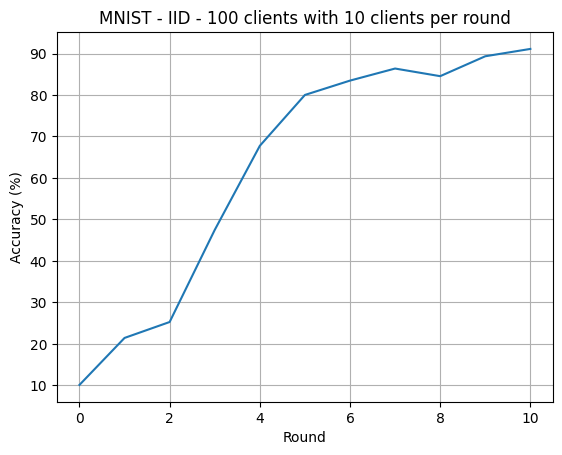

In [22]:
print(f"{history.metrics_centralized = }")

global_accuracy_centralised = history.metrics_centralized["accuracy"]
round = [data[0] for data in global_accuracy_centralised]
acc = [100.0 * data[1] for data in global_accuracy_centralised]
plt.plot(round, acc)
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.title("MNIST - IID - 100 clients with 10 clients per round")

# Effect of Quantization Schemes on FL

Now, we will run the Flower simulation while changing the parameters of the `Quantizer` class to observe how the accuracy of the FL model changes.

In [23]:
# Set config parameters in multiple for loops
# rr = {False, True}
# sr = {'det', 'rand'}
# k = {2, 3, 4}
# Total = 2*2*3 + 1 = 13 plots (one for no quantization as reference, done earlier.)
for k in [1, 2, 3]:
  for rr in [False, True]:
    for sr in ['det', 'rand']:
      # Set parameters in quantizer
      qr.set_config(rr, sr, k)
      # Run the FL simulation
      history = fl.simulation.start_simulation(
        client_fn=client_fn_callback,  # a callback to construct a client
        num_clients=NUM_CLIENTS,  # total number of clients in the experiment
        config=fl.server.ServerConfig(num_rounds=10),  # let's run for 10 rounds
        strategy=strategy,  # the strategy that will orchestrate the whole FL pipeline
        client_resources=client_resources,
      )
      # Add to history_list and label_list
      history_list.append(history)
      cfg = dict(qr.get_config())
      label_list.append(cfg)

INFO flwr 2023-11-01 11:24:41,420 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-11-01 11:24:46,168	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-11-01 11:24:48,901 | app.py:210 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'memory': 7854327399.0, 'object_store_memory': 3927163699.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'memory': 7854327399.0, 'object_store_memory': 3927163699.0}
INFO flwr 2023-11-01 11:24:48,909 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO:flwr:Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2023-11-01 11:24:48,971 | app.py:270 | Flower VCE: Creating 

Having collected all of our results in `history_list`, it is now time to plot them against each other! We use subplots for various number of bits used in the quantization, and compare the results of each quantization method to the result obtained without using quantization.

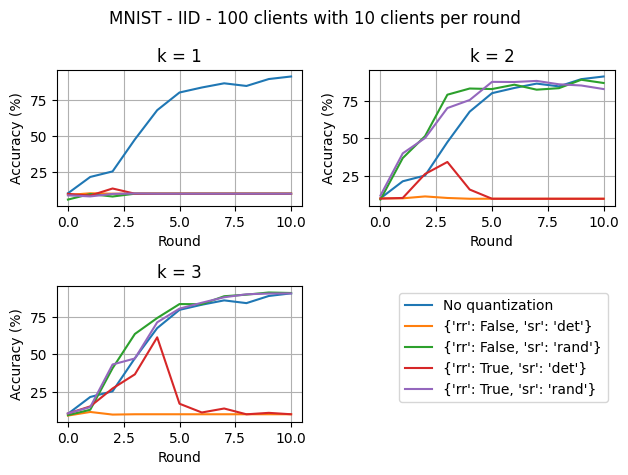

In [24]:

def plot_result(history, label, axObj):
  # Extract accuracy and round number data
  global_accuracy_centralised = history.metrics_centralized["accuracy"]
  round = [data[0] for data in global_accuracy_centralised]
  acc = [100.0 * data[1] for data in global_accuracy_centralised]
  # Plot accuracy as a function of round number
  axObj.plot(round, acc, label=label)
  return

# Generate 2x2 subplots, last one is left blank.
fig, axs = plt.subplots(2, 2)
axs[-1, -1].axis('off')

# Plot the first (no quantization) result in ALL subplots for reference
for ax in axs.flat[:-1]:
  plot_result(history_list[0], label_list[0], ax)

for hist, lb in zip(history_list[1:], label_list[1:]):
  # Decide which axis to plot on
  axObj = axs[-1, -1]
  if lb['k'] == 1:
    axObj = axs[0, 0]
  elif lb['k'] == 2:
    axObj = axs[0, 1]
  else:
    axObj = axs[1, 0]
  # Plot results on that axis
  lgd_lbl = dict(lb)
  del lgd_lbl['k']
  plot_result(hist, str(lgd_lbl), axObj)

# Figure aesthetics for all axes
k = 1
for ax in axs.flat[:-1]:
  ax.grid()
  ax.set(ylabel="Accuracy (%)", xlabel="Round")
  ax.title.set_text("k = " + str(k))
  k += 1

# Global legend
h, l = axs[1, 0].get_legend_handles_labels()
plt.legend(h, l)
# Global title
plt.suptitle("MNIST - IID - 100 clients with 10 clients per round")
fig.tight_layout()

## Conclusion

From the above figure, we can conclude the following:

1. Using biased deterministic rounding leads to poor accuracy.
2. Unbiased randomized rounding gives accuracy close to the unquantized accuracy.
3. Using a random rotation matrix improves accuracy. In the case of deterministic rounding, accuracy first increases with round number, but the bias becomes the dominating factor and accuracy then starts to decrease.
4. For \\(k = 1\\), a lot of information is lost in quantization and thus the accuracy is poor, unlike for \\(k > 1\\).

The best alternative to quantization would be to use randomized rounding only since for this scalar quantization scheme, using a random rotation does not give significant improvements. Note that this choice comes at a cost of \\(\mathcal{O}(n)\\) bits of randomness, where \\(n\\) is the size of the vector to be quantized.